# Imports

In [ ]:
!pip install scikit-learn matplotlib pandas tensorflow # python version 3.9.6

In [6]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import os

# Naive modelisation
Let's try to make prediction based only on Mohamed Salah's statistics 

The idea is to predict the goals on next match given the last 5 matchs

In [7]:
def create_sequences(data, target_column, seq_length):
    """
    Generates temporal sequences and corresponding target values for model training.

    Parameters:
    ----------
    data : pandas.DataFrame
        Input data containing features and the target column.
    target_column : str
        Name of the target column to predict.
    seq_length : int
        Number of time steps in each sequence.

    Returns:
    -------
    sequences : numpy.ndarray
        Array of shape `(n_sequences, seq_length, n_features)` containing the feature sequences.
    targets : numpy.ndarray
        Array of shape `(n_sequences,)` containing the target values.

    Notes:
    -----
    - Assumes data is sorted by time.
    - Excludes the 'date' and target columns from sequences.
    """
    sequences = []
    targets = []
    
    for i in range(len(data) - seq_length):
        # Ajouter une séquence de longueur seq_length
        sequences.append(data.iloc[i:i + seq_length].drop(columns=[target_column, 'date']).values)
        # Ajouter la cible correspondante
        targets.append(data.iloc[i + seq_length][target_column])
    
    return np.array(sequences), np.array(targets)

In [61]:
# Load and preprocess data
df = pd.read_csv("data/Mohamed Salah.csv")  # Load the dataset
df = df.sort_values(by='date').reset_index(drop=True)  # Ensure data is sorted by time

# Normalize feature columns (excluding target and date)
features_to_normalize = df.drop(columns=["goals", "date"]).columns
scaler = StandardScaler()
df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])

# Create sequences for time series modeling
seq_length = 5  # Number of time steps in each sequence
X, y = create_sequences(df, target_column="goals", seq_length=seq_length)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Display shapes of training and testing datasets
print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)


Training data shape: (18, 5, 13) (18,)
Testing data shape: (9, 5, 13) (9,)


In [62]:
# Instantiate and train the Linear Regression model
model = LinearRegression()

# Flatten sequences into 2D arrays for compatibility with the model
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Fit the model to the training data
model.fit(X_train_flat, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test_flat)

# Evaluate the model's performance
print("MSE (Linear Regression):", mean_squared_error(y_test, y_pred))
print("R² (Linear Regression):", r2_score(y_test, y_pred))


MSE (Linear Regression): 0.29066356339547855
R² (Linear Regression): -0.3079860352796535


### Analysis of Results

- The **negative \( R^2 \)** (-0.308) indicates that the model performs worse than a simple mean-based prediction of the target values.

### Possible Causes

1. **Data Size**:
   - Only **27 observations** in total, split into **18 for training** and **9 for testing**. This small dataset makes it challenging for the model to learn meaningful relationships.

2. **Sequence Issues**:
   - Each input sequence contains 5 observations with 13 features, resulting in a flattened input vector of **65 dimensions**. With only 18 training samples, the model is likely to **overfit** or fail to learn effectively.

3. **Model Inappropriateness**:
   - Linear regression may not be suitable for capturing temporal or nonlinear relationships in the data.

### Possible Improvements

- **Increase the dataset size**:
  - Collect more data to improve the model's generalization capability.


# Building a More Robust Model

To enhance the model's performance and generalization, the idea is to incorporate **data from multiple forward players**. By expanding the dataset beyond a single player's data, we aim to capture a wider range of playing styles, patterns, and variability in performance. This approach helps the model learn **generalizable insights** instead of overfitting to the specific traits of one player.

### Why This Matters

- **Diverse Data**: Including multiple forwards introduces variability, making the model better at recognizing universal patterns.
- **Reduced Overfitting**: A broader dataset helps prevent the model from becoming too tailored to one player.
- **Improved Predictions**: By generalizing across players, the model can provide more accurate and robust predictions for unseen data.

Let’s take this model from narrow and specialized to wide and impactful!


In [65]:
# Path to the folder containing data files
path_root = 'data'
files_path = [os.path.join(path_root, file_name) for file_name in os.listdir(path_root)]

# Parameters
seq_length = 5  # Length of each input sequence
sequences = []
targets = []

# Iterate over all data files to process and combine data
for file in files_path:
    try:
        # Load data from the current file
        df = pd.read_csv(file)
        
        # Create sequences and corresponding targets
        seq, targ = create_sequences(df, target_column="goals", seq_length=seq_length)
        
        # Check compatibility of sequence and target dimensions
        if seq.shape[0] == targ.shape[0] and seq.ndim == 3 and targ.ndim == 1:
            # Append sequences and targets to the main dataset
            if len(sequences) == 0:
                sequences = seq
                targets = targ
            else:
                sequences = np.concatenate((sequences, seq), axis=0)
                targets = np.concatenate((targets, targ), axis=0)
        else:
            print(f"File ignored: {file} - Incompatible dimensions (seq: {seq.shape}, targ: {targ.shape})")
    except Exception as e:
        print(f"Error processing file {file}: {e}")

# Final data check
print("Final shape of sequences:", sequences.shape)
print("Final shape of targets:", targets.shape)


File ignored: data/Divin Mubama.csv - Incompatible dimensions (seq: (0,), targ: (0,))
Final shape of sequences: (1162, 5, 13)
Final shape of targets: (1162,)


1. Linear Regression

In [69]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
# 80% of the data is used for training, and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(
    sequences, targets, test_size=0.2, random_state=42
)

# Display the shapes of the resulting datasets
print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)


Training data shape: (929, 5, 13) (929,)
Testing data shape: (233, 5, 13) (233,)


In [70]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and apply the transformation
# The data is reshaped into 2D for scaling and then reshaped back to its original shape
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)

# Apply the same transformation to the test data
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test.shape)

# Display the shapes of the normalized datasets
print("Normalized training data shape:", X_train_scaled.shape)
print("Normalized testing data shape:", X_test_scaled.shape)

Normalized training data shape: (929, 5, 13)
Normalized testing data shape: (233, 5, 13)


In [71]:
# Flatten sequences for Linear Regression (RL) and Random Forest (RF)
# Each sequence is reshaped from 3D (samples, time steps, features) to 2D (samples, flattened features)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Display the shapes of the flattened datasets
print("Flattened training data shape for RL and RF:", X_train_flat.shape)
print("Flattened testing data shape for RL and RF:", X_test_flat.shape)


Flattened training data shape for RL and RF: (929, 65)
Flattened testing data shape for RL and RF: (233, 65)


In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Train the Linear Regression model
model_rl = LinearRegression()
model_rl.fit(X_train_flat, y_train)

# Make predictions on the test data
y_pred_rl = model_rl.predict(X_test_flat)

# Evaluate the model using MSE and R² metrics
mse_rl = mean_squared_error(y_test, y_pred_rl)
r2_rl = r2_score(y_test, y_pred_rl)

# Print evaluation results
print("MSE (RL):", mse_rl)
print("R² (RL):", r2_rl)


MSE (RL): 0.492513597289767
R² (RL): -0.2534282786019968


In [72]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Train the Random Forest model
# Random Forest uses multiple decision trees to improve predictions
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train_flat, y_train)

# Make predictions on the test data
y_pred_rf = model_rf.predict(X_test_flat)

# Evaluate the model using MSE and R² metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print evaluation results
print("MSE (RF):", mse_rf)
print("R² (RF):", r2_rf)


MSE (RF): 0.40620085836909875
R² (RF): -0.03765473367212513


In [52]:
!pip install tensorflow


In [73]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score

# Build the LSTM model
model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)  # Output layer for a single prediction
])

# Compile the model
# Using Mean Squared Error (MSE) as loss and Mean Absolute Error (MAE) as a metric
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train the model
history = model_lstm.fit(
    X_train, y_train, 
    epochs=50, batch_size=16, 
    validation_split=0.2, verbose=1
)

# Make predictions on the test data
y_pred_lstm = model_lstm.predict(X_test).flatten()

# Evaluate the model
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)

# Print evaluation results
print("MSE (LSTM):", mse_lstm)
print("R² (LSTM):", r2_lstm)


Epoch 1/50


/Users/mounir/Desktop/Premier-League-Simulation/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 53.3325 - mae: 5.1688 - val_loss: 4.5458 - val_mae: 1.6210
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5881 - mae: 1.4107 - val_loss: 1.5773 - val_mae: 0.9769
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1985 - mae: 0.8418 - val_loss: 0.8624 - val_mae: 0.7246
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6093 - mae: 0.6068 - val_loss: 0.5431 - val_mae: 0.5553
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4909 - mae: 0.5398 - val_loss: 0.4710 - val_mae: 0.5399
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4166 - mae: 0.5031 - val_loss: 0.5516 - val_mae: 0.5487
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4082 - mae: 0.4762 - val_loss: 0.4885 - val_mae: 0.5218
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3941 - mae: 0.4742 - val_loss: 0.4454 - val_mae: 0.5144
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3759 - mae: 0.4762 - v

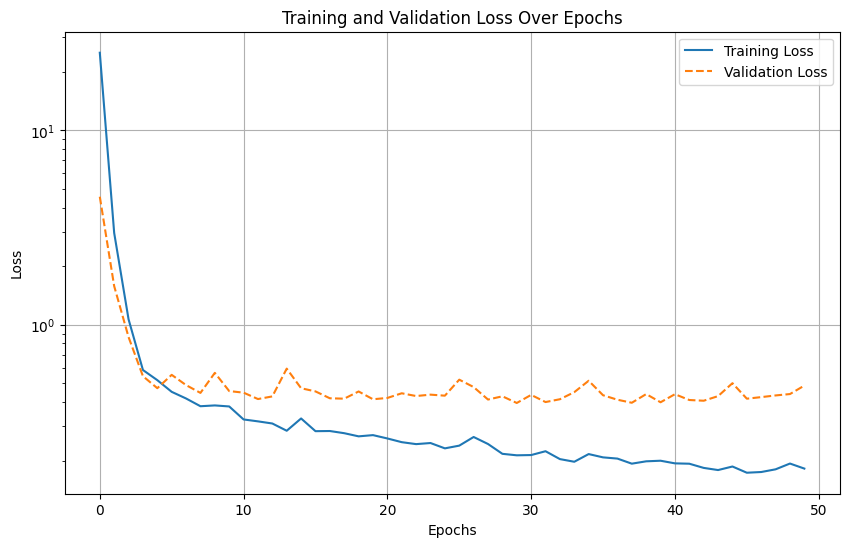

In [74]:
import matplotlib.pyplot as plt

# Extraire les données de perte (loss) et de validation (val_loss)
loss = history.history['loss']
val_loss = history.history['val_loss']

# Tracer les courbes
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()


# Résultats

### Model Performance Summary

The results indicate limited performance across models for sequential data prediction. Below is a brief evaluation and improvement suggestions for each model:

| Modèle                   | MSE      | R²       |
|--------------------------|----------|----------|
| Régression Linéaire (RL) | 0.4925   | -0.2534  |
| Random Forest (RF)       | 0.4062   | -0.0376  |
| LSTM                    | 0.6022   | -0.5383  |

---

#### **Linear Regression (LR)**
- **Results**: MSE = 0.4925, R² = -0.2534.
- **Analysis**: 
  - Linear regression struggles to capture complex or temporal dependencies in the data.
  - A negative R² shows the model performs worse than predicting the mean.
- **Challenges**: Inability to model nonlinear or sequential relationships.
- **Improvements**: 
  - Apply nonlinear feature transformations.
  - Introduce more relevant explanatory variables.

---

#### **Random Forest (RF)**
- **Results**: MSE = 0.4062, R² = -0.0376
- **Analysis**: 
  - RF slightly outperforms LR, but its near-zero R² indicates it poorly explains data variance.
  - RF does not inherently handle sequential dependencies well.
- **Challenges**: Limited ability to exploit temporal structures and sensitivity to hyperparameters.
- **Improvements**: 
  - Tune hyperparameters (e.g., tree depth, number of estimators).
  - Explore gradient boosting models (XGBoost, LightGBM).

---

#### **LSTM**
- **Results**: MSE = 0.6022, R² = -0.5383
- **Analysis**: 
  - Despite being designed for sequential data, the LSTM underperforms, likely due to insufficient data or suboptimal hyperparameters.
  - Neural networks require larger datasets to generalize effectively.
- **Challenges**: Risk of overfitting on small datasets, slow convergence with non-optimized settings.
- **Improvements**: 
  - Expand dataset size or perform data augmentation.
  - Optimize architecture (e.g., dropout, batch normalization, hyperparameter tuning).

---

### General Recommendations
1. **Data Quality**: Improve data preprocessing and include more relevant features (rank of two teams).
2. **Dataset Size**: Collect more data or augment existing data to enhance model performance.
